In [ ]:
Terkoneksi dengan drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
path="gdrive/MyDrive/DATA/"

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import re
import numpy as np
import ast
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy import sparse
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB

In [ ]:
df=pd.read_excel(path+"DataHasilPreprocessing (9 Mei 2023, pukul 21.45).xlsx",usecols=["tokenize","label"])

In [ ]:
# join list of token as single document string
import ast

def join_text_list(texts):
    texts = ast.literal_eval(texts)
    return ' '.join([text for text in texts])
df["join"] = df["tokenize"].apply(join_text_list)
df["join"].head()

0    langgan indihome internet cepat aplikasi aplik...
1                                       aplikasi bagus
2    aplikasi mudah laku transaksi pilih menu simpe...
3    terimakasih aplikasi bantu banget mudah transaksi
4                       jarang kendala internet stabil
Name: join, dtype: object

In [ ]:
# banyaknya term yang akan digunakan,
max_features = 1260

# Feature Engineering
print ("------- TF-IDF on data -------")

tf_idf = TfidfVectorizer(max_features=max_features, binary=False)
tfidf_mat = tf_idf.fit_transform(df["join"]).toarray()

print("TF-IDF ", type(tfidf_mat), tfidf_mat.shape)

------- TF-IDF on data -------
TF-IDF  <class 'numpy.ndarray'> (994, 1260)


In [ ]:
terms = tf_idf.get_feature_names_out()

# sum tfidf frequency of each term through documents
sums = tfidf_mat.sum(axis=0)

# connecting term to its sums frequency
data = []
for col, term in enumerate(terms):
    data.append((term, sums[col] ))

ranking = pd.DataFrame(data, columns=['term','rank'])
ranking.sort_values('rank', ascending=False)

,term,rank
55,aplikasi,95.072461
77,bagus,68.892887
731,mudah,60.691639
413,indihome,50.435855
94,bantu,45.055792
...,...,...
181,catat,0.168310
999,segitu,0.164975
783,nonaktif,0.164975
254,diweb,0.154381


In [ ]:
max_features = 1260

# calc TF vector
cvect = CountVectorizer(max_features=max_features)
TF_vector = cvect.fit_transform(df["join"])

# calc IDF
tfidf = TfidfVectorizer(max_features=max_features, norm=None, smooth_idf=False)
tfs = tfidf.fit_transform(df["join"])
IDF_vector = tfidf.idf_

# hitung TF x IDF sehingga dihasilkan TFIDF matrix / vector
tfidf_mat = TF_vector.multiply(IDF_vector).toarray()
tfidf_mat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
max_features = 1260

def generate_tfidf_mat(min_gram, max_gram):
    cvect = CountVectorizer(max_features=max_features, ngram_range=(min_gram, max_gram))
    counts = cvect.fit_transform(df["join"])

    tfidf = TfidfVectorizer(max_features=max_features, norm=None, ngram_range=(min_gram, max_gram), smooth_idf=False)
    tfs = tfidf.fit_transform(df["join"])

    tfidf_mat = counts.multiply(tfidf.idf_).toarray()

    TF = counts.toarray()
    IDF = tfidf.idf_
    TF_IDF = tfidf_mat
    return TF, IDF, TF_IDF, tfidf.get_feature_names_out()

# ngram_range (1, 1) to use unigram only
tf_mat_unigram, idf_mat_unigram, tfidf_mat_unigram, terms_unigram = generate_tfidf_mat(1,1)

# ---------- check sparse data -------------------
idx_sample = 0

print("Show TFIDF sample ke-" + str(idx_sample), "\n")
print(df["tokenize"][idx_sample], "\n")

print("\t\t\t", "TF", "\t\t", "IDF", "\t\t", "TF-IDF", "\t", "Term\n")
for i, item in enumerate(zip(tf_mat_unigram[idx_sample], idf_mat_unigram, tfidf_mat_unigram[idx_sample], terms_unigram)):
    if(item[2] != 0.0):
        print ("array position " + str(i) + "\t",
               "%.6f" % item[0], "\t",
               "%.6f" % item[1], "\t",
               "%.6f" % item[2], "\t",
               item[3])

Show TFIDF sample ke-0 

['langgan', 'indihome', 'internet', 'cepat', 'aplikasi', 'aplikasi', 'ulang', 'modem', 'klik', 'cepat', 'internet', 'terimakasih', 'indihome', 'tani', 'sukses'] 

			 TF 		 IDF 		 TF-IDF 	 Term

array position 55	 2.000000 	 1.659514 	 3.319028 	 aplikasi
array position 186	 2.000000 	 2.801871 	 5.603742 	 cepat
array position 413	 2.000000 	 2.408676 	 4.817352 	 indihome
array position 433	 2.000000 	 3.011388 	 6.022776 	 internet
array position 541	 1.000000 	 5.068524 	 5.068524 	 klik
array position 592	 1.000000 	 2.989082 	 2.989082 	 langgan
array position 718	 1.000000 	 4.810695 	 4.810695 	 modem
array position 1080	 1.000000 	 5.416831 	 5.416831 	 sukses
array position 1105	 1.000000 	 6.803125 	 6.803125 	 tani
array position 1140	 1.000000 	 4.051590 	 4.051590 	 terimakasih
array position 1201	 1.000000 	 4.051590 	 4.051590 	 ulang


In [ ]:
# nilai TF
x=df["tokenize"]
cv=CountVectorizer()
word_count_vector=cv.fit_transform(x)
tf2=pd.DataFrame(word_count_vector.toarray(), columns=cv.get_feature_names_out())

In [ ]:
def get_TF_unigram(row):
    idx = row.name
    return [tf for tf in tf_mat_unigram[idx] if tf != 0.0]

df["TF_UNIGRAM"] = df.apply(get_TF_unigram, axis=1)

def get_IDF_unigram(row):
    idx = row.name
    return [item[1] for item in zip(tf_mat_unigram[idx], idf_mat_unigram) if item[0] != 0.0]

df["IDF_UNIGRAM"] = df.apply(get_IDF_unigram, axis=1)

def get_TFIDF_unigram(row):
    idx = row.name
    return [tfidf for tfidf in tfidf_mat_unigram[idx] if tfidf != 0.0]

df["TFIDF_UNIGRAM"] = df.apply(get_TFIDF_unigram, axis=1)

df[["tokenize", "TF_UNIGRAM", "IDF_UNIGRAM", "TFIDF_UNIGRAM"]].head()

# save TFIDF Unigram to Excel
df[["tokenize", "TF_UNIGRAM", "IDF_UNIGRAM", "TFIDF_UNIGRAM"]].to_excel("TFIDF_Unigram.xlsx")

In [ ]:
# save sparse matrix unigram to .npz file
sparse.save_npz("tfidf_mat_unigram.npz", sparse.csr_matrix(tfidf_mat_unigram))

In [ ]:
# untuk mendapatkan sparse unigram pembobotan TF-IDF
import scipy.sparse as sp
tfidf_mat_unigram = sp.csc_matrix(tfidf_mat_unigram)
tfidf_mat_unigram = tfidf_mat_unigram.tocsc()
tfidf_mat_unigram = pd.DataFrame.sparse.from_spmatrix(tfidf_mat_unigram)
tfidf_mat_unigram.to_excel('Pembobotan TF-IDF Python (9 Mei 2023, pukul 21.45).xlsx', index=False)

In [ ]:
def get_sparse_n_tags(file_names, dataset_name):

    # load preprocessed dataset as dataframe
    LABEL_DATA = pd.read_excel(dataset_name, usecols=["label"])
    tags = LABEL_DATA.label

    # load sparse matrix
    unigram = sparse.load_npz(file_names[0]).toarray()

    return [unigram, tags]

sparse_file_names = ["tfidf_mat_unigram.npz",]
preprocessed_dataset_name = "DataHasilPreprocessing (9 Mei 2023, pukul 21.45).xlsx"

sparse_unigram, tags = \
                        get_sparse_n_tags(sparse_file_names, preprocessed_dataset_name)

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
tags = label_encoder.fit_transform(tags)

In [ ]:
def split_dataset(sparse, tags, split_ratio):
    # split dataset
    return train_test_split(sparse, tags, test_size=split_ratio, random_state=False)


sparse_unigram_train, sparse_unigram_test, tags_train, tags_test = split_dataset(sparse_unigram, tags, 0.10)

In [ ]:
# untuk mendapatkan sparse unigram data training sebelum seleksi fitur
import scipy.sparse as sp
sparse_unigram_train = sp.csc_matrix(sparse_unigram_train)
sparse_unigram_train = sparse_unigram_train.tocsc()
df_train = pd.DataFrame.sparse.from_spmatrix(sparse_unigram_train)
df_train.to_excel('Data Training Sebelum Seleksi Fitur (9 Mei 2023, pukul 21.45).xlsx', index=False)
# untuk mendapatkan sparse unigram label data training sebelum seleksi fitur
import scipy.sparse as sp
tags_train = sp.csc_matrix(tags_train)
tags_train = tags_train.tocsc()
tags_train = pd.DataFrame.sparse.from_spmatrix(tags_train)
tags_train.to_excel('Label Data Training Sebelum Seleksi Fitur (9 Mei 2023, pukul 21.45).xlsx', index=False)

In [ ]:
# untuk mendapatkan sparse unigram data testing sebelum seleksi fitur
import scipy.sparse as sp
sparse_unigram_test = sp.csc_matrix(sparse_unigram_test)
sparse_unigram_test  = sparse_unigram_test .tocsc()
df_test = pd.DataFrame.sparse.from_spmatrix(sparse_unigram_test)
df_test.to_excel('Data Testing Sebelum Seleksi Fitur (9 Mei 2023, pukul 21.45).xlsx', index=False)
# untuk mendapatkan sparse unigram label data testing sebelum seleksi fitur
import scipy.sparse as sp
tags_test = sp.csc_matrix(tags_test)
tags_test = tags_test.tocsc()
tags_test = pd.DataFrame.sparse.from_spmatrix(tags_test)
tags_test.to_excel('Label Data Testing Sebelum Seleksi Fitur (9 Mei 2023, pukul 21.45).xlsx', index=False)

In [ ]:
naive_bayes_classifier=MultinomialNB()
naive_bayes_classifier.fit(sparse_unigram_train, tags_train)

MultinomialNB()

In [ ]:
# Prediksi Y
y_pred = naive_bayes_classifier.predict(sparse_unigram_test)

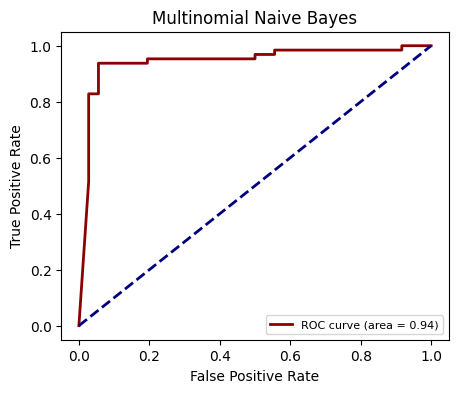

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
pred_mnb = naive_bayes_classifier.predict_proba(sparse_unigram_test)[:,1]
fpr_mnb,tpr_mnb,_ = roc_curve(tags_test,pred_mnb)
roc_auc_mnb = auc(fpr_mnb,tpr_mnb)

f, axes = plt.subplots(1, 1, figsize=(5, 4))
plt.plot(fpr_mnb, tpr_mnb, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_mnb))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim=[-0.01, 1.0]
plt.ylim=[-0.01, 1.05]
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multinomial Naive Bayes')
plt.legend(loc='lower right', fontsize=8)

In [ ]:
# Evaluasi Model Tanpa Seleksi Fitur
from sklearn.metrics import roc_auc_score
print(classification_report(tags_test,y_pred))
auc = round(roc_auc_score(tags_test,y_pred),2)
print(f'AUC Score MNB = {auc*100}%')

              precision    recall  f1-score   support

           0       0.89      0.92      0.90        36
           1       0.95      0.94      0.94        64

    accuracy                           0.93       100
   macro avg       0.92      0.93      0.92       100
weighted avg       0.93      0.93      0.93       100

AUC Score MNB = 93.0%


In [ ]:
cnf_matrix = confusion_matrix(tags_test,y_pred)
cnf_matrix

array([[33,  3],
       [ 4, 60]])

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from scipy import sparse
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)

# read sparse matrix yang sebelumnya disimpan pada file .npz
tfidf_mat_unigram = sparse.load_npz("tfidf_mat_unigram.npz").toarray()

# read label/class dari xlsx preprocessing untuk keperluan fiture selection
tags = pd.read_excel(path+"DataHasilPreprocessing (9 Mei 2023, pukul 21.45).xlsx",usecols=["label"])

# calculate mutual info (MI) / information gain (GI) untuk tiap feature
mi_unigram = mutual_info_classif(tfidf_mat_unigram, tags.label, discrete_features=True)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.1

In [ ]:
x=df["tokenize"]
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(x)
tfidf_feature_names = vectorizer.get_feature_names_out()

In [ ]:
ig_data = pd.DataFrame({'Unigram': list(tfidf_feature_names), 'Information_Gain': mi_unigram})

In [ ]:
ig_data

,Unigram,Information_Gain
0,abal,0.001077
1,abis,0.000036
2,acak,0.000105
3,acara,0.000423
4,acung,0.000423
...,...,...
1255,yaaaa,0.000423
1256,yaelah,0.001077
1257,yukk,0.000423
1258,yyyyyyyyyyyyyy,0.001077


In [ ]:
ig_data.to_excel("information_gain.xlsx")

In [ ]:
mi_unigram[terms=="abal"]

array([0.00107728])

In [ ]:
# sum tfidf frequency of each term through documents
sums_unigram = tfidf_mat_unigram.sum(axis=0)

def generate_ranking(terms, sums):
    # connecting term to its sums frequency
    data = []
    for col, term in enumerate(terms):
        data.append((term, sums[col] ))
    ranking = pd.DataFrame(data, columns=['term','rank'])
    return ranking.sort_values('rank', ascending=False)

ranking_unigram = generate_ranking(terms_unigram, sums_unigram)

# show top 10 rank (total tfidf) unigram
print(ranking_unigram.head(10))

         term         rank
55   aplikasi  1155.021703
413  indihome   761.141541
731     mudah   712.885280
603     layan   596.903657
186     cepat   543.562931
592   langgan   505.154912
77      bagus   497.013700
94      bantu   469.442126
103     bayar   465.925758
433  internet   457.730988


In [ ]:
# get all column index on norm_mi below 0.001
def get_column_idx(mi_item, threshold):
    return [i for i, mi_item in enumerate(mi_item) if mi_item < threshold]

column_idx_unigram = get_column_idx(mi_unigram, 0.001)

# delete sparse matrix tfidf_mat where column=column_id, save into new array
tfidf_mat_selection_unigram = np.delete(tfidf_mat_unigram, column_idx_unigram ,1)

# number of feature after reduction
max_features_unigram = tfidf_mat_selection_unigram.shape[1]

In [ ]:
max_features_unigram

633

In [ ]:
tfidf_mat_selection_unigram

,0,1,2,3,4,5,6,7,8,9,...,623,624,625,626,627,628,629,630,631,632
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# untuk mendapatkan sparse unigram data training sebelum seleksi fitur
import scipy.sparse as sp

# Convert NumPy array to CSC sparse matrix
tfidf_mat_selection_unigram = sp.csc_matrix(tfidf_mat_selection_unigram)

# Now you can use the to_csc method
tfidf_mat_selection_unigram = tfidf_mat_selection_unigram.tocsc()

import pandas as pd
# Konversi sparse_unigram_train menjadi dataframe
tfidf_mat_selection_unigram = pd.DataFrame.sparse.from_spmatrix(tfidf_mat_selection_unigram)

# Menyimpan dataframe ke file Excel
tfidf_mat_selection_unigram.to_excel('tfidf_mat_selection_unigram.xlsx', index=False)

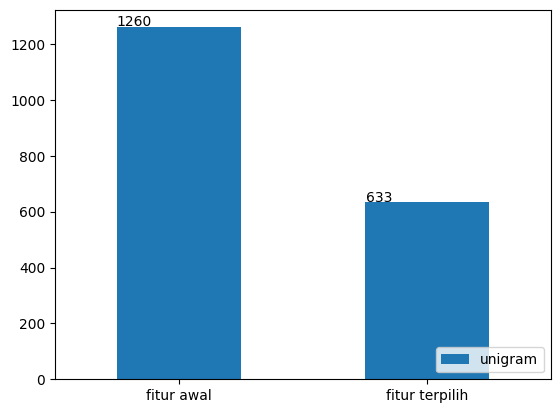

In [ ]:
# plot number of feature on bar chart

groups = [tfidf_mat_unigram.shape[1], tfidf_mat_selection_unigram.shape[1]]

group_labels = ['fitur awal', 'fitur terpilih']

# Convert data to pandas DataFrame.
df1 = pd.DataFrame(groups, index=group_labels, columns=["unigram"])

# plot into bar chart
ax = df1.plot(kind='bar', rot=0)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

ax.legend(loc='lower right')

In [ ]:
from scipy import sparse
import json

#------------------------------------------------------------------------------------------------------
# save sparse matrix unigram to .npz file
sparse.save_npz("tfidf_mat_selection_unigram.npz", sparse.csr_matrix(tfidf_mat_selection_unigram))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from scipy import sparse
from sklearn.naive_bayes import MultinomialNB

from datetime import datetime
import pandas as pd
import pickle

In [ ]:
def get_sparse_n_tags(file_names, dataset_name):

    # load preprocessed dataset as dataframe
    LABEL_DATA2 = pd.read_excel(dataset_name, usecols=["label"])
    label = LABEL_DATA2.label

    # load sparse matrix
    unigram = sparse.load_npz(file_names[0]).toarray()

    return [unigram, label]

sparse_file_names2 = ["tfidf_mat_selection_unigram.npz",]
preprocessed_dataset_name2 = "DataHasilPreprocessing (9 Mei 2023, pukul 21.45).xlsx"

sparse_unigram2, label = \
                        get_sparse_n_tags(sparse_file_names2, preprocessed_dataset_name2)

In [ ]:
from sklearn.preprocessing import LabelEncoder
label1 = LabelEncoder()
label = label1.fit_transform(label)

In [ ]:
sparse_unigram2.shape

(994, 633)

In [ ]:
def split_dataset(sparse2, tags2, split_ratio):
    # split dataset
    return train_test_split(sparse2, label, test_size=split_ratio, random_state=False)


sparse_unigram_train2, sparse_unigram_test2, label_train, label_test = split_dataset(sparse_unigram2, tags, 0.10)

In [ ]:
naive_bayes_classifier1=MultinomialNB()
naive_bayes_classifier1.fit(sparse_unigram_train2, label_train)

MultinomialNB()

In [ ]:
# Prediksi Y
y_pred1 = naive_bayes_classifier1.predict(sparse_unigram_test2)

In [ ]:
# Evaluasi Model Dengan Seleksi Fitur
from sklearn.metrics import roc_auc_score
print(classification_report(label_test,y_pred1))
auc = round(roc_auc_score(label_test,y_pred1),2)
print(f'AUC Score MNB = {auc*100}%')

              precision    recall  f1-score   support

           0       0.94      0.92      0.93        36
           1       0.95      0.97      0.96        64

    accuracy                           0.95       100
   macro avg       0.95      0.94      0.95       100
weighted avg       0.95      0.95      0.95       100

AUC Score MNB = 94.0%


In [ ]:
cnf_matrix = confusion_matrix(label_test,y_pred1)
cnf_matrix

array([[33,  3],
       [ 2, 62]])

In [ ]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

In [ ]:
df=pd.read_excel("DataHasilPreprocessing (9 Mei 2023, pukul 21.45).xlsx", usecols=["tokenize","label"])

In [ ]:
grouped_df = df.groupby("label")["tokenize"].apply(lambda x: ' '.join(x)).reset_index()

In [ ]:
word_counts_by_label = {}
for index, row in grouped_df.iterrows():
    label = row["label"]
    words = row["tokenize"].split()
    word_counts = pd.Series(words).value_counts()
    word_counts_by_label[label] = word_counts

In [ ]:
for label, word_counts in word_counts_by_label.items():
    print(f"Kelas: {label}")
    top_15_words = word_counts.head(15)
    print(top_15_words)
    print()

Kelas: negative
'aplikasi',     108
['aplikasi',     66
'bijak',         50
'ulang',         49
'privasi',       46
'layan',         44
'lapor',         44
'masuk',         41
'muncul',        38
'langgan',       36
'pakai',         33
'internet',      33
'buka',          33
'kirim',         31
'indihome',      31
dtype: int64

Kelas: positive
'aplikasi',      246
'mudah',         239
['aplikasi',     228
'indihome',      191
'cepat',         150
'layan',         143
'bantu',         118
'bayar',         112
'tagih',         104
'langgan',       100
'internet',       98
'fitur',          97
'bagus',          95
'myindihome',     93
'banget',         87
dtype: int64



In [ ]:
wc=pd.read_excel(path+"DataHasilPreprocessing(9 Mei 2023, pukul 21.45).xlsx",usecols=["tokenize","label"])

In [ ]:
grouped_wc = wc.groupby("label")["tokenize"].apply(lambda x: ' '.join(x)).reset_index()

In [ ]:
word_counts_by_label = {}
for index, row in grouped_wc.iterrows():
    label = row["label"]
    words = row["tokenize"].split()
    word_counts = pd.Series(words).value_counts()
    word_counts_by_label[label] = word_counts

In [ ]:
for label, word_counts in word_counts_by_label.items():
    print(f"Kelas: {label}")
    top_15_words = word_counts.head(15)
    print(top_15_words)
    print()

Kelas: negative
'aplikasi',     108
['aplikasi',     66
'bijak',         50
'ulang',         49
'privasi',       46
'layan',         44
'lapor',         44
'masuk',         41
'muncul',        38
'langgan',       36
'pakai',         33
'internet',      33
'buka',          33
'kirim',         31
'indihome',      31
dtype: int64

Kelas: positive
'aplikasi',      246
'mudah',         239
['aplikasi',     228
'indihome',      191
'cepat',         150
'layan',         143
'bantu',         118
'bayar',         112
'tagih',         104
'langgan',       100
'internet',       98
'fitur',          97
'bagus',          95
'myindihome',     93
'banget',         87
dtype: int64



In [ ]:
wc_pos=wc[wc["label"]=="positive"]
wc_neg=wc[wc["label"]=="negative"]

In [ ]:
# convert to list
pos_list=wc_pos["tokenize"].tolist()
neg_list=wc_neg["tokenize"].tolist()

In [ ]:
filtered_positive=("").join(str(pos_list))
filtered_positive=filtered_positive.lower()

filtered_negative=("").join(str(neg_list))
filtered_negative=filtered_negative.lower()

In [ ]:
word_freq_pos=Counter(filtered_positive.split())
word_freq_neg=Counter(filtered_negative.split())

In [ ]:
top_10_pos=dict(word_freq_pos.most_common(9))
top_10_neg=dict(word_freq_neg.most_common(9))

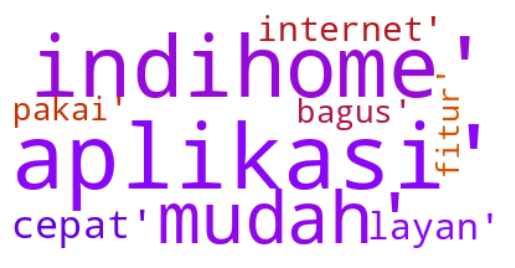

In [ ]:
wordcloud=WordCloud(max_words=9,max_font_size=160,margin=0,background_color="white",colormap="gnuplot").generate(filtered_positive)
plt.figure("off")
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

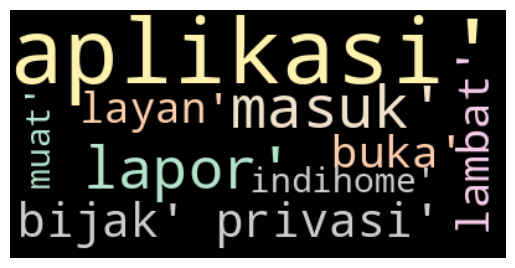

In [ ]:
wordcloud=WordCloud(max_words=9, max_font_size=160,margin=0,background_color="black",colormap="Pastel2_r").generate(filtered_negative)
plt.figure("off")
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()